# Improved BERT + LightGBM for Predicting Week of Sale with Calibrated Probabilities with Hypertuning and Feature Engineering

In [1]:
#!pip install transformers torch lightgbm scikit-learn pandas optuna -q


Step 1: Imports

In [22]:
import pandas as pd
import numpy as np
import torch
from transformers import DistilBertTokenizerFast, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import mean_squared_error, mean_absolute_error


Step 2: Load and Preprocess Data

In [3]:
df = pd.read_csv("Coles_synthetic_8weeks_v3_cleaned.csv")
df['Week_num'] = df['Week'].str.extract(r'Week\s*(\d+)').astype(int)
df = df.sort_values(by=['product_code', 'Week_num'])
df['was_on_special_last_week'] = df.groupby('product_code')['IsOnSpecial'].shift(1).fillna(0)


Step 3: Create Target: Next Sale Week
python
Copy
Edit


In [4]:
def find_next_sale_weeks(group):
    week_nums = group['Week_num'].values
    sale_flags = group['IsOnSpecial'].values
    next_sale_week = []
    for i in range(len(sale_flags)):
        for j in range(i + 1, len(sale_flags)):
            if sale_flags[j] == 1:
                next_sale_week.append(week_nums[j])
                break
        else:
            next_sale_week.append(None)
    group['next_on_sale_week'] = next_sale_week
    return group

df = df.groupby('product_code', group_keys=False).apply(find_next_sale_weeks)
df.dropna(subset=['next_on_sale_week'], inplace=True)
df['next_on_sale_week'] = df['next_on_sale_week'].astype(int)


C:\Users\utkar\AppData\Local\Temp\ipykernel_26740\1374946541.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df.groupby('product_code', group_keys=False).apply(find_next_sale_weeks)
C:\Users\utkar\AppData\Local\Temp\ipykernel_26740\1374946541.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('product_code', group_keys=False).apply(find_next_sale_weeks)


Step 4: Feature Engineering

In [5]:
def add_time_since_last_sale(df):
    result = []
    for _, group in df.groupby('product_code'):
        last_sale = -1
        temp = []
        for _, row in group.iterrows():
            temp.append(0 if last_sale == -1 else row['Week_num'] - last_sale)
            if row['IsOnSpecial'] == 1:
                last_sale = row['Week_num']
        result.extend(temp)
    df['time_since_last_sale'] = result
    return df

df = add_time_since_last_sale(df)
df['discount_count'] = df.groupby('product_code')['IsOnSpecial'].transform('sum')
df['discount_frequency'] = df['discount_count'] / df.groupby('product_code')['Week_num'].transform('count')
df['avg_discount_rate'] = df.groupby('product_code')['DiscountRate'].transform('mean')
df['product_frequency'] = df.groupby('product_code')['Week_num'].transform('count')


Step 5: BERT Embedding + PCA

In [6]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model_bert = DistilBertModel.from_pretrained("distilbert-base-uncased")

def get_bert_embeddings(text_list, tokenizer, model, batch_size=64):
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    all_embeddings = []
    with torch.no_grad():
        for i in range(0, len(text_list), batch_size):
            inputs = tokenizer(text_list[i:i+batch_size], return_tensors="pt", padding=True, truncation=True, max_length=32).to(device)
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(embeddings)
    return np.vstack(all_embeddings)

embeddings = get_bert_embeddings(df["item_name"].tolist(), tokenizer, model_bert)
pca = PCA(n_components=100)
embeddings_reduced = pca.fit_transform(embeddings)


Step 6: Prepare Final Dataset

In [7]:
structured = df[[
    'item_price', 'unit_price', 'DiscountRate', 'PriceCapped', 'Week_num',
    'was_on_special_last_week', 'time_since_last_sale',
    'discount_frequency', 'avg_discount_rate', 'product_frequency'
]].values

X = np.hstack((structured, embeddings_reduced))
y = df['next_on_sale_week']


Step 7: Optuna Hyperparameter Tuning

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': 9,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
    }
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return f1_score(y_test, preds, average='macro')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_params = study.best_params
best_params.update({'objective': 'multiclass', 'num_class': 9})


[I 2025-05-17 19:02:57,947] A new study created in memory with name: no-name-cd9682a0-5327-4662-92fb-90f75f630cf6


[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] Start training from score -1.783301
[LightGBM] [Info] Start training from score -1.714824
[LightGBM] [Warning] No further s

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:03:04,110] Trial 0 finished with value: 0.6927476618150813 and parameters: {'learning_rate': 0.010265190779598572, 'num_leaves': 132, 'max_depth': 6, 'min_data_in_leaf': 66}. Best is trial 0 with value: 0.6927476618150813.


[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] S

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:03:07,334] Trial 1 finished with value: 0.823016084727423 and parameters: {'learning_rate': 0.0649313403262977, 'num_leaves': 31, 'max_depth': 14, 'min_data_in_leaf': 56}. Best is trial 1 with value: 0.823016084727423.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] S

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:03:10,159] Trial 2 finished with value: 0.7442445180222027 and parameters: {'learning_rate': 0.04807753320485713, 'num_leaves': 70, 'max_depth': 5, 'min_data_in_leaf': 70}. Best is trial 1 with value: 0.823016084727423.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] Start training from score -1.783301
[LightGBM] [Info] Start training from score -1.714824
[LightGBM] [Warning] No further s

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:03:15,118] Trial 3 finished with value: 0.5844790095450063 and parameters: {'learning_rate': 0.27640447952579716, 'num_leaves': 101, 'max_depth': 11, 'min_data_in_leaf': 96}. Best is trial 1 with value: 0.823016084727423.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] S

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:03:18,475] Trial 4 finished with value: 0.7673105718156463 and parameters: {'learning_rate': 0.12033659208815352, 'num_leaves': 34, 'max_depth': 14, 'min_data_in_leaf': 58}. Best is trial 1 with value: 0.823016084727423.


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] S

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:03:22,784] Trial 5 finished with value: 0.7522677089405914 and parameters: {'learning_rate': 0.011654117841078233, 'num_leaves': 62, 'max_depth': 9, 'min_data_in_leaf': 94}. Best is trial 1 with value: 0.823016084727423.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] S

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:03:25,527] Trial 6 finished with value: 0.6735846503493281 and parameters: {'learning_rate': 0.22431451679620262, 'num_leaves': 57, 'max_depth': 6, 'min_data_in_leaf': 13}. Best is trial 1 with value: 0.823016084727423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ign

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:03:27,254] Trial 7 finished with value: 0.6380964849674982 and parameters: {'learning_rate': 0.04054413972210795, 'num_leaves': 75, 'max_depth': 3, 'min_data_in_leaf': 26}. Best is trial 1 with value: 0.823016084727423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:03:29,409] Trial 8 finished with value: 0.7527532009011056 and parameters: {'learning_rate': 0.08569370375522437, 'num_leaves': 145, 'max_depth': 4, 'min_data_in_leaf': 56}. Best is trial 1 with value: 0.823016084727423.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] Start training from score -1.783301
[LightGBM] [Info] Start training from score -1.714824
[LightGBM] [Warning] No further s

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:03:34,519] Trial 9 finished with value: 0.8646414767502177 and parameters: {'learning_rate': 0.09860821942771096, 'num_leaves': 101, 'max_depth': 8, 'min_data_in_leaf': 30}. Best is trial 9 with value: 0.8646414767502177.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] S

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:03:38,703] Trial 10 finished with value: 0.746360595453697 and parameters: {'learning_rate': 0.16802196328248908, 'num_leaves': 107, 'max_depth': 8, 'min_data_in_leaf': 32}. Best is trial 9 with value: 0.8646414767502177.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] S

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:03:41,867] Trial 11 finished with value: 0.7746552916784157 and parameters: {'learning_rate': 0.13484836173865256, 'num_leaves': 35, 'max_depth': 15, 'min_data_in_leaf': 40}. Best is trial 9 with value: 0.8646414767502177.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] S

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:03:44,541] Trial 12 finished with value: 0.7974243789686468 and parameters: {'learning_rate': 0.08364963316551244, 'num_leaves': 20, 'max_depth': 12, 'min_data_in_leaf': 44}. Best is trial 9 with value: 0.8646414767502177.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] S

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:03:50,170] Trial 13 finished with value: 0.8872076991166025 and parameters: {'learning_rate': 0.09516333978053199, 'num_leaves': 112, 'max_depth': 9, 'min_data_in_leaf': 78}. Best is trial 13 with value: 0.8872076991166025.


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] S

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:03:55,467] Trial 14 finished with value: 0.9008985030371787 and parameters: {'learning_rate': 0.1757944480898243, 'num_leaves': 112, 'max_depth': 8, 'min_data_in_leaf': 81}. Best is trial 14 with value: 0.9008985030371787.


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] Start training from score -1.783301
[LightGBM] [Info] Start training from score -1.714824
[LightGBM] [Warning] No further s

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:04:00,936] Trial 15 finished with value: 0.723642010596907 and parameters: {'learning_rate': 0.1829525781347195, 'num_leaves': 121, 'max_depth': 11, 'min_data_in_leaf': 82}. Best is trial 14 with value: 0.9008985030371787.


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] Start training from score -1.783301
[LightGBM] [Info] Start training from score -1.714824
[LightGBM] [Warning] No further s

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:04:04,829] Trial 16 finished with value: 0.7613922685258039 and parameters: {'learning_rate': 0.2039875589463454, 'num_leaves': 118, 'max_depth': 7, 'min_data_in_leaf': 82}. Best is trial 14 with value: 0.9008985030371787.


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] S

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:04:10,613] Trial 17 finished with value: 0.5904956568588646 and parameters: {'learning_rate': 0.2511271789473256, 'num_leaves': 150, 'max_depth': 10, 'min_data_in_leaf': 81}. Best is trial 14 with value: 0.9008985030371787.


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] S

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:04:15,699] Trial 18 finished with value: 0.8960883396001207 and parameters: {'learning_rate': 0.13509486733556428, 'num_leaves': 90, 'max_depth': 9, 'min_data_in_leaf': 71}. Best is trial 14 with value: 0.9008985030371787.


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] Start training from score -1.783301
[LightGBM] [Info] Start training from score -1.714824
[LightGBM] [Warning] No further s

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:04:20,807] Trial 19 finished with value: 0.817296536151333 and parameters: {'learning_rate': 0.1405643345514838, 'num_leaves': 88, 'max_depth': 12, 'min_data_in_leaf': 71}. Best is trial 14 with value: 0.9008985030371787.


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Inf

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:04:24,634] Trial 20 finished with value: 0.74716422263692 and parameters: {'learning_rate': 0.1903565016586893, 'num_leaves': 88, 'max_depth': 7, 'min_data_in_leaf': 100}. Best is trial 14 with value: 0.9008985030371787.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info]

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:04:30,415] Trial 21 finished with value: 0.8960674341624524 and parameters: {'learning_rate': 0.11567623299893035, 'num_leaves': 114, 'max_depth': 9, 'min_data_in_leaf': 86}. Best is trial 14 with value: 0.9008985030371787.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.85870

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:04:35,525] Trial 22 finished with value: 0.8700674640321758 and parameters: {'learning_rate': 0.157319320299316, 'num_leaves': 95, 'max_depth': 9, 'min_data_in_leaf': 89}. Best is trial 14 with value: 0.9008985030371787.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] S

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:04:41,941] Trial 23 finished with value: 0.9005537888117341 and parameters: {'learning_rate': 0.11356649921151402, 'num_leaves': 130, 'max_depth': 10, 'min_data_in_leaf': 89}. Best is trial 14 with value: 0.9008985030371787.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] S

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:04:47,672] Trial 24 finished with value: 0.7919461036840222 and parameters: {'learning_rate': 0.15582735819847632, 'num_leaves': 133, 'max_depth': 11, 'min_data_in_leaf': 74}. Best is trial 14 with value: 0.9008985030371787.


[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] S

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:04:52,754] Trial 25 finished with value: 0.6209339986214557 and parameters: {'learning_rate': 0.21989550890963125, 'num_leaves': 130, 'max_depth': 10, 'min_data_in_leaf': 66}. Best is trial 14 with value: 0.9008985030371787.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] Start training from score -1.783301
[LightGBM] [Info] Start training from score -1.714824
[LightGBM] [Warning] No further s

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:04:57,231] Trial 26 finished with value: 0.8788922379839763 and parameters: {'learning_rate': 0.13045802998269423, 'num_leaves': 79, 'max_depth': 8, 'min_data_in_leaf': 87}. Best is trial 14 with value: 0.9008985030371787.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] S

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:05:01,724] Trial 27 finished with value: 0.8473706283229423 and parameters: {'learning_rate': 0.11214307087127082, 'num_leaves': 140, 'max_depth': 7, 'min_data_in_leaf': 63}. Best is trial 14 with value: 0.9008985030371787.


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] S

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:05:07,141] Trial 28 finished with value: 0.7869817018830672 and parameters: {'learning_rate': 0.1710532142534873, 'num_leaves': 124, 'max_depth': 10, 'min_data_in_leaf': 92}. Best is trial 14 with value: 0.9008985030371787.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26189
[LightGBM] [Info] Number of data points in the train set: 98297, number of used features: 110
[LightGBM] [Info] Start training from score -5.759176
[LightGBM] [Info] Start training from score -2.457146
[LightGBM] [Info] Start training from score -2.140962
[LightGBM] [Info] Start training from score -1.930675
[LightGBM] [Info] Start training from score -1.858704
[LightGBM] [Info] Start training from score -1.933625
[LightGBM] [Info] S

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-17 19:05:10,294] Trial 29 finished with value: 0.7307352522085819 and parameters: {'learning_rate': 0.1472907883866702, 'num_leaves': 134, 'max_depth': 6, 'min_data_in_leaf': 47}. Best is trial 14 with value: 0.9008985030371787.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


Step 8: Train Final Calibrated Model

In [9]:
base_model = lgb.LGBMClassifier(**best_params)
calibrated_model = CalibratedClassifierCV(base_model, method='isotonic', cv=3)
calibrated_model.fit(X_train, y_train)


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26191
[LightGBM] [Info] Number of data points in the train set: 65531, number of used features: 110
[LightGBM] [Info] Start training from score -5.757560
[LightGBM] [Info] Start training from score -2.457082
[LightGBM] [Info] Start training from score -2.140913
[LightGBM] [Info] Start training from score -1.930600
[LightGBM] [Info] Start training from score -1.858764
[LightGBM] [Info] Start training from score -1.933656
[LightGBM] [Info] Start training from score -1.783356
[LightGBM] [Info] Start training from score -1.714848
[LightGBM] [Warning] No further s

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26185
[LightGBM] [Info] Number of data points in the train set: 65531, number of used features: 110
[LightGBM] [Info] Start training from score -5.762402
[LightGBM] [Info] Start training from score -2.457082
[LightGBM] [Info] Start training from score -2.140913
[LightGBM] [Info] Start training from score -1.930705
[LightGBM] [Info] Start training from score -1.858666
[LightGBM] [Info] Start training from score -1.933656
[LightGBM] [Info] Start training from score -1.783265
[LightGBM] [Info] Start training from score -1.714848
[LightGBM] [Warning] No further s

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26190
[LightGBM] [Info] Number of data points in the train set: 65532, number of used features: 110
[LightGBM] [Info] Start training from score -5.757575
[LightGBM] [Info] Start training from score -2.457275
[LightGBM] [Info] Start training from score -2.141059
[LightGBM] [Info] Start training from score -1.930721
[LightGBM] [Info] Start training from score -1.858681
[LightGBM] [Info] Start training from score -1.933565
[LightGBM] [Info] S

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


CalibratedClassifierCV(cv=3,
                       estimator=LGBMClassifier(learning_rate=0.1757944480898243,
                                                max_depth=8,
                                                min_data_in_leaf=81,
                                                num_class=9, num_leaves=112,
                                                objective='multiclass'),
                       method='isotonic')

Step 9: Evaluation

c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
Accuracy: 0.8908240081383519
              precision    recall  f1-score   support

           1       0.25      0.03      0.05        78
           2       0.77      0.89      0.82      2106
           3       0.82      0.85      0.84      2888
           4       0.88      0.86      0.87      3565
           5       0.89      0.88      0.88      3831
           6       0.92      0.88      0.90      3554
           7       0.94      0.91      0.93      4130
           8       0.96      0.96      0.96      4423

    accuracy                           0.89     24575
   macro avg       0.80      0.78      0.78     24575
weighted avg       0.89      0.89      0.89     24575



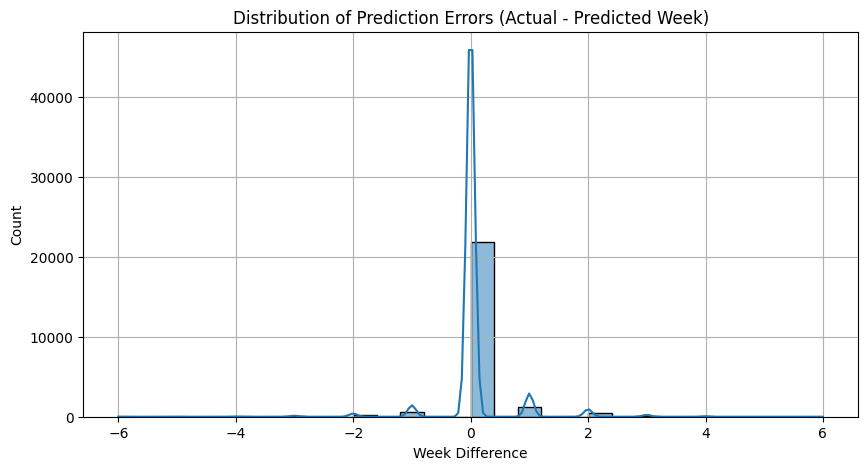

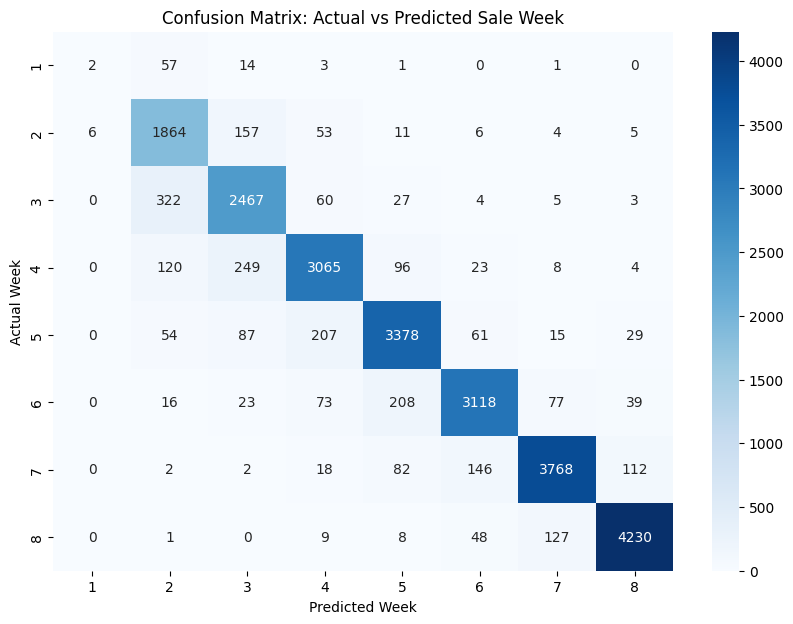

In [10]:
y_pred = calibrated_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Errors
errors = y_test - y_pred
plt.figure(figsize=(10, 5))
sns.histplot(errors, bins=30, kde=True)
plt.title("Distribution of Prediction Errors (Actual - Predicted Week)")
plt.xlabel("Week Difference")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=range(1, 9))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 9), yticklabels=range(1, 9))
plt.xlabel("Predicted Week")
plt.ylabel("Actual Week")
plt.title("Confusion Matrix: Actual vs Predicted Sale Week")
plt.show()


In [18]:
# Macro-average (good for multiclass)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"🔍 Precision (macro): {precision:.4f}")
print(f"📢 Recall (macro): {recall:.4f}")
print(f"🎯 F1 Score (macro): {f1:.4f}")

# Optionally, micro and weighted scores:
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_micro = f1_score(y_test, y_pred, average='micro')

print(f"\n(Micro Average) Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1: {f1_micro:.4f}")

precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"(Weighted Average) Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1: {f1_weighted:.4f}")

🔍 Precision (macro): 0.8020
📢 Recall (macro): 0.7816
🎯 F1 Score (macro): 0.7797

(Micro Average) Precision: 0.8908, Recall: 0.8908, F1: 0.8908
(Weighted Average) Precision: 0.8914, Recall: 0.8908, F1: 0.8903


<Figure size 1000x600 with 0 Axes>

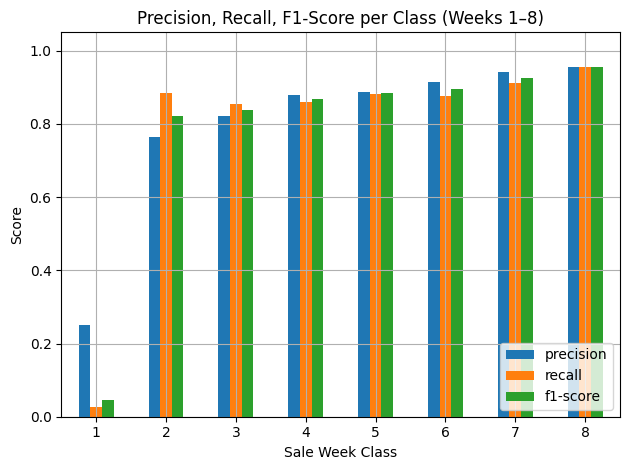

In [21]:
# Generate classification report from full test set
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Filter class-specific rows (Weeks 1 to 8)
class_rows = [str(i) for i in range(1, 9)]
metrics_df = report_df.loc[class_rows, ['precision', 'recall', 'f1-score']].astype(float)

# Plot bar chart
plt.figure(figsize=(10, 6))
metrics_df.plot(kind='bar')
plt.title("Precision, Recall, F1-Score per Class (Weeks 1–8)")
plt.xlabel("Sale Week Class")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.legend(loc="lower right")
plt.show()


In [19]:
def predict_next_sale_week(item_name, structured_values, tokenizer, model_bert, pca, model_lgb):
    model_bert.eval()
    inputs = tokenizer([item_name], return_tensors="pt", padding=True, truncation=True, max_length=32)
    with torch.no_grad():
        outputs = model_bert(**inputs)
        embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    embedding_pca = pca.transform(embedding)
    final_input = np.hstack((structured_values, embedding_pca))
    pred_class = model_lgb.predict(final_input)[0]
    prob_dist = model_lgb.predict_proba(final_input)[0]
    return int(pred_class), {week+1: round(prob, 3) for week, prob in enumerate(prob_dist)}


Step 10: Sample Predcition

In [20]:
item_name = "Sanitarium Up & Go Liquid Breakfast Choc Ice 3x250ml"

structured_features = np.array([[
    2.5,    # item_price
    1.25,   # unit_price
    0.20,   # DiscountRate
    0,      # PriceCapped
    1,      # Week_num
    0,      # was_on_special_last_week
    1,      # time_since_last_sale
    0.25,   # discount_frequency
    0.18,   # avg_discount_rate
    8       # product_frequency
]])

predicted_week, probabilities = predict_next_sale_week(
    item_name=item_name,
    structured_values=structured_features,
    tokenizer=tokenizer,
    model_bert=model_bert,
    pca=pca,
    model_lgb=calibrated_model
)

print(f"🔮 Predicted next sale week: Week {predicted_week}")
print("📊 Probabilities:", probabilities)


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
🔮 Predicted next sale week: Week 2
📊 Probabilities: {1: np.float64(0.003), 2: np.float64(0.347), 3: np.float64(0.276), 4: np.float64(0.178), 5: np.float64(0.158), 6: np.float64(0.027), 7: np.float64(0.007), 8: np.float64(0.004)}


c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\utkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: U

In [23]:
# Calculate errors
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"📉 RMSE: {rmse:.4f} weeks")
print(f"📊 MAE: {mae:.4f} weeks")

📉 RMSE: 0.5259 weeks
📊 MAE: 0.1538 weeks
